# Example Notebook for the tunneling Fermions

This Notebook is based on the following [paper](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.114.080402) from the Jochim group. In these experiments two fermions of different spins are put into a single tweezer and then coupled to a second tweezer. The dynamics is then controlled by two competing effects. The interactions and the tunneling. 

Let us first start by looking at the data, then look how the can be described in the Hamiltonian language and finally in the gate language.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm

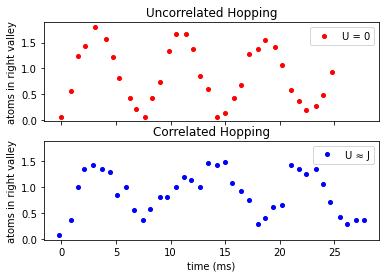

In [2]:
data_murmann_no_int = pd.read_csv("Data/Murmann_No_Int.csv", names=["time", "nR"])
data_murmann_with_int = pd.read_csv("Data/Murmann_With_Int.csv", names=["time", "nR"])

# plt.figure(dpi=96)
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
ax1.set_title('Uncorrelated Hopping')
ax1.plot(
    data_murmann_no_int.time, data_murmann_no_int.nR, "ro", label="U = 0", markersize=4
)
ax2.set_title('Correlated Hopping')
ax2.plot(
    data_murmann_with_int.time,
    data_murmann_with_int.nR,
    "bo",
    label="U ≈ J",
    markersize=4,
)
ax1.set_ylabel(r"atoms in right valley")
ax2.set_ylabel(r"atoms in right valley")
ax2.set_xlabel(r"time (ms)")
ax1.legend()
ax2.legend()

## Analytical prediction

For the two atoms the Hamiltonian can be written down in the basis $\{LL, LR, RL, RR\}$ as:
    
$$
H = \left(\begin{array}{cccc}
U & -J & -J & 0\\
-J & 0 & 0 &-J\\
-J & 0 & 0 &-J\\
0 & -J & -J & U
            \end{array}
            \right)
$$

And we start out in the basis state $|LL\rangle$. So we can write

In [3]:
from scipy.sparse.linalg import expm

In [4]:
J = np.pi * 134
# in units of hbar
U = 0.7 * J;

In [5]:
Nt_an = 50
t_analytical = np.linspace(0, 20, Nt_an) * 1e-3
H_With_Int = np.array([[U, -J, -J, 0], [-J, 0, 0, -J], [-J, 0, 0, -J], [0, -J, -J, U]])
H_Wo_Int = np.array([[0, -J, -J, 0], [-J, 0, 0, -J], [-J, 0, 0, -J], [0, -J, -J, 0]])

In [6]:
psi0 = np.zeros(4) * 1j
psi0[0] = 1.0 + 0j
print(psi0)

[1.+0.j 0.+0.j 0.+0.j 0.+0.j]


In [7]:
psis_wo_int = 1j * np.zeros((4, Nt_an))
psis_w_int = 1j * np.zeros((4, Nt_an))

for ii in np.arange(Nt_an):

    U_wo = expm(-1j * t_analytical[ii] * H_Wo_Int)
    psis_wo_int[:, ii] = np.dot(U_wo, psi0)

    U_w = expm(-1j * t_analytical[ii] * H_With_Int)
    psis_w_int[:, ii] = np.dot(U_w, psi0)

ps_wo = np.abs(psis_wo_int) ** 2
ps_w = np.abs(psis_w_int) ** 2

In [8]:
nR_wo = ps_wo[1, :] + ps_wo[2, :] + 2 * ps_wo[3, :]
nR_w = ps_w[1, :] + ps_w[2, :] + 2 * ps_w[3, :];

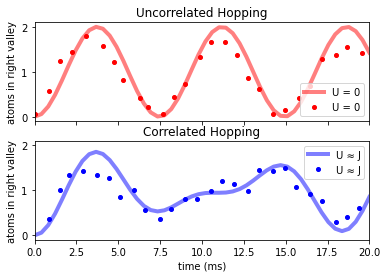

In [9]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)
ax1.set_title('Uncorrelated Hopping')
ax1.plot(t_analytical * 1e3, nR_wo, "r-", label="U = 0", linewidth=4, alpha=0.5)
ax1.plot(
    data_murmann_no_int.time, data_murmann_no_int.nR, "ro", label="U = 0", markersize=4
)

ax2.set_title('Correlated Hopping')
ax2.plot(t_analytical * 1e3, nR_w, "b-", label="U ≈ J", linewidth=4, alpha=0.5)
ax2.plot(
    data_murmann_with_int.time,
    data_murmann_with_int.nR,
    "bo",
    label="U ≈ J",
    markersize=4,
)
ax1.set_ylabel(r"atoms in right valley")
ax2.set_ylabel(r"atoms in right valley")
ax2.set_xlabel(r"time (ms)")
ax2.set_xlim(0, 20)
ax1.legend()
ax2.legend()

## Qiskit

And now we also compare to the Qiskit simulation. Make sure that you followed the necessary steps for obtaining the credentials as desribed in the [introduction](https://github.com/Qiskit-Extensions/qiskit-cold-atom/blob/main/docs/tutorials/05_cold_atom_provider.ipynb).

In [10]:
from qiskit_cold_atom.providers import ColdAtomProvider

# save an account to disk
provider = ColdAtomProvider.enable_account(url = ["http://qsimsim.synqs.org/singlequdit", "http://qsimsim.synqs.org/fermions"], username="synqs_test",token="Cm2TXfRmXennMQ5")

In [11]:
fermion_device_backend = provider.get_backend("synqs_fermionic_tweezer_simulator")

In the experiments two Fermions are loaded onto the right side, i.e. into the wire 0 and 1. 

## No interaction
In a first set of experiments there are no interactions and the two atoms are simply allowed to hop. The experiment is then described by the following very simple circuit.

In [12]:
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit_cold_atom.synqs_fermions import LoadGate

In [13]:
theta_j = Parameter("theta_j")

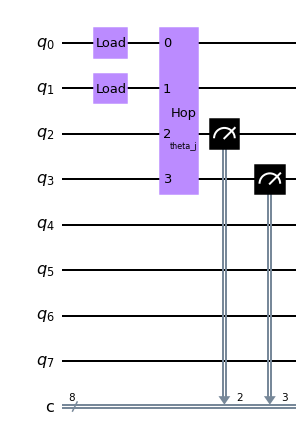

In [14]:
circuit1 = QuantumCircuit(8,8)
circuit1.load(0)
circuit1.load(1)
circuit1.hop(list(range(0,4)), theta_j)
circuit1.measure(2,2)
circuit1.measure(3,3)
circuit1.draw(output='mpl')

In [15]:
Ntimes = 15
times = np.linspace(0, 20, Ntimes)* 1e-3
theta_js = -1 * J * times
means = np.zeros(Ntimes)

In [16]:
circuit1_list = [circuit1.bind_parameters({theta_j: theta%(2*np.pi)}) for theta in theta_js]

In [17]:
job1 = fermion_device_backend.run(circuit1_list, shots = 500)

In [18]:
job1.job_id()

'20211116_123930-fermions-synqs_test-79caa'

In [19]:
job_retrieved1 = fermion_device_backend.retrieve_job(job_id = job1.job_id())

print("job status: ", job_retrieved1.status())

job status:  JobStatus.INITIALIZING


In [20]:
result1 = job_retrieved1.result()
#print(type(result1))

In [21]:
outcomes1 = [result1.get_memory(i) for i in range(len(circuit1_list))]

In [22]:
for i in tqdm(range(Ntimes)):
    means[i] = np.array(list(map(str.split,outcomes1[i]))).astype('int').sum(axis=1).mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 529.60it/s]


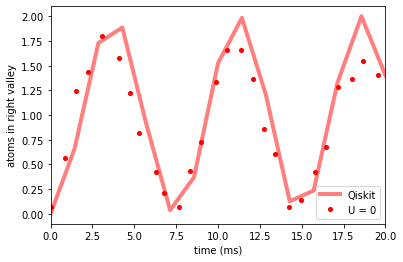

In [23]:
f, ax1 = plt.subplots(1, 1, sharex=True, sharey=True)
ax1.plot(times * 1e3, means, "r-", label="Qiskit", linewidth=4, alpha=0.5)
ax1.plot(
    data_murmann_no_int.time, data_murmann_no_int.nR, "ro", label="U = 0", markersize=4
)
ax1.set_ylabel(r"atoms in right valley")
ax1.set_xlabel(r"time (ms)")
ax1.legend()
ax1.set_xlim(0, 20);

## Hopping with interactions

In a next step the atoms are interacting. The circuit description of the experiment is the application of the hopping gate and the interaction gate. It can be written as

In [24]:
theta_j = Parameter("theta_j")
theta_u = Parameter("theta_u")

In [25]:
Ntimes = 15
times = np.linspace(0, 20, Ntimes)* 1e-3
theta_js = -1 * J * times
theta_us = U * times
means_int = np.zeros(Ntimes)
Ntrott=15

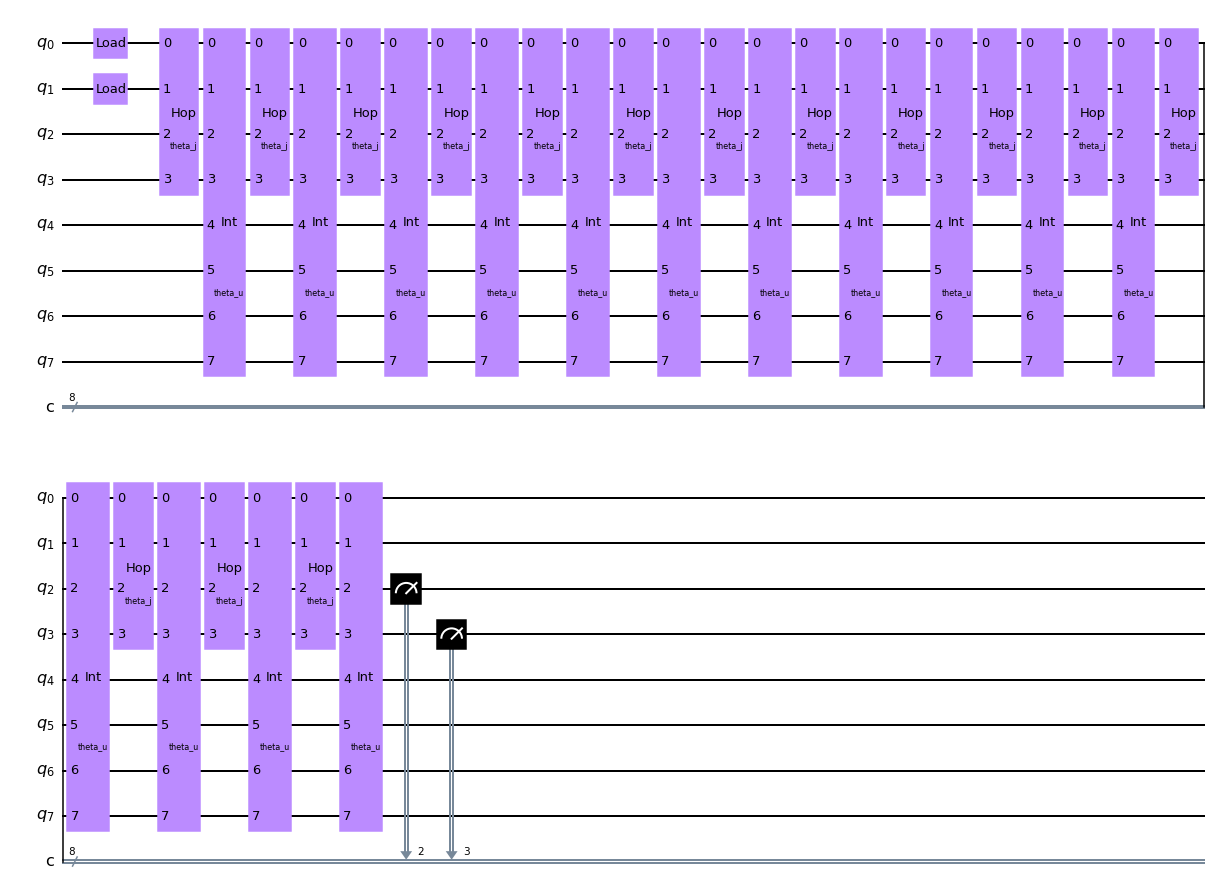

In [26]:
circuit2 = QuantumCircuit(8,8)
circuit2.load(0)
circuit2.load(1)
for ii in range(Ntrott):
    circuit2.hop(list(range(0,4)), theta_j)
    circuit2.inter(list(range(0,8)), theta_u)
circuit2.measure(2,2)
circuit2.measure(3,3);
circuit2.draw(output='mpl')

In [27]:
circuit2_list = [circuit2.bind_parameters({theta_j: (theta1/Ntrott)%(2*np.pi),theta_u: (theta2/Ntrott)%(2*np.pi)}) for (theta1,theta2) in zip(theta_js,theta_us)]

In [28]:
job2 = fermion_device_backend.run(circuit2_list, shots = 500)

In [29]:
job2.job_id()

'20211116_123958-fermions-synqs_test-49426'

In [30]:
job_retrieved2 = fermion_device_backend.retrieve_job(job_id = job2.job_id())

print("job status: ", job_retrieved2.status())

job status:  JobStatus.INITIALIZING


In [31]:
result2 = job_retrieved2.result()
#print(type(result1))

In [32]:
outcomes2 = [result2.get_memory(i) for i in range(len(circuit2_list))]

In [33]:
for i in tqdm(range(Ntimes)):
    means_int[i] = np.array(list(map(str.split,outcomes2[i]))).astype('int').sum(axis=1).mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 933.45it/s]


(0.0, 20.0)

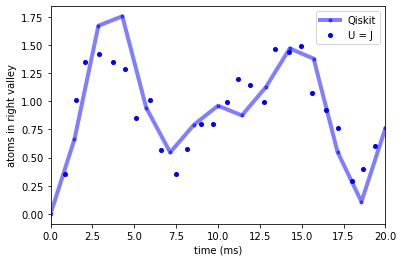

In [34]:
f, ax2 = plt.subplots(1, 1, sharex=True, sharey=True)

ax2.plot(times * 1e3, means_int, "b.-", label="Qiskit", linewidth=4, alpha=0.5)
ax2.plot(
    data_murmann_with_int.time,
    data_murmann_with_int.nR,
    "bo",
    label="U = J",
    markersize=4,
)
ax2.set_ylabel(r"atoms in right valley")
ax2.set_xlabel(r"time (ms)")
ax2.legend()
ax2.set_xlim(0, 20)

## Summary

And finally we can compare the experimental data with all the descriptions.

(-1.0, 20.0)

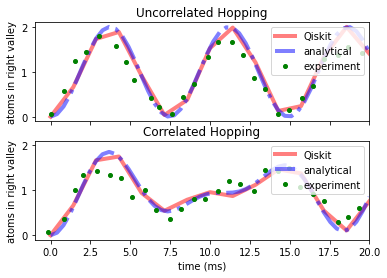

In [35]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True)


ax1.set_title('Uncorrelated Hopping')
ax1.plot(times * 1e3, means, "r-", label="Qiskit", linewidth=4, alpha=0.5)
ax1.plot(t_analytical * 1e3, nR_wo, "b-.", label="analytical", linewidth=4, alpha=0.5)
ax1.plot(
    data_murmann_no_int.time,
    data_murmann_no_int.nR,
    "go",
    label="experiment",
    markersize=4,
)

ax2.set_title('Correlated Hopping')
ax2.plot(times * 1e3, means_int, "r-", label="Qiskit", linewidth=4, alpha=0.5)
ax2.plot(t_analytical * 1e3, nR_w, "b-.", label="analytical", linewidth=4, alpha=0.5)
ax2.plot(
    data_murmann_with_int.time,
    data_murmann_with_int.nR,
    "go",
    label="experiment",
    markersize=4,
)
ax1.set_ylabel(r"atoms in right valley")
ax2.set_ylabel(r"atoms in right valley")
ax2.set_xlabel(r"time (ms)")
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
ax1.set_xlim(-1, 20)